# Kaggle Shelter Animal Outcomes

https://www.kaggle.com/c/shelter-animal-outcomes

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

The train and test data are randomly split. 

In [598]:
import matplotlib.pyplot as plt
%matplotlib inline

In [507]:
import pandas as pd

train = pd.read_csv('train.csv.gz')

In [508]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [509]:
len(train)

26729

In [510]:
train.isnull().sum()/train.size

AnimalID          0.000000
Name              0.028774
DateTime          0.000000
OutcomeType       0.000000
OutcomeSubtype    0.050926
AnimalType        0.000000
SexuponOutcome    0.000004
AgeuponOutcome    0.000067
Breed             0.000000
Color             0.000000
dtype: float64

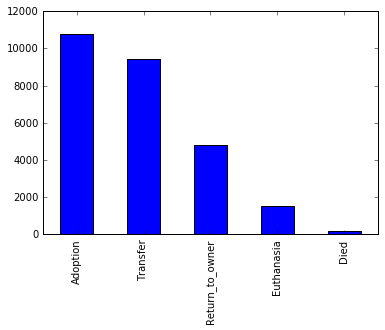

In [511]:
train['OutcomeType'].value_counts().plot(kind='bar')

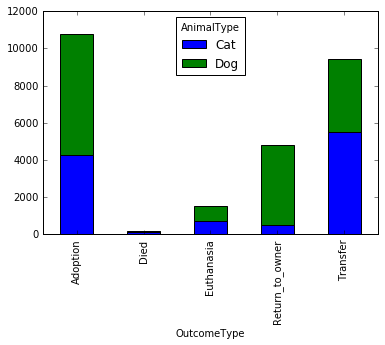

In [512]:
train.pivot_table(values='AnimalID', index='OutcomeType', columns='AnimalType', aggfunc='count').plot(kind='bar', stacked=True)

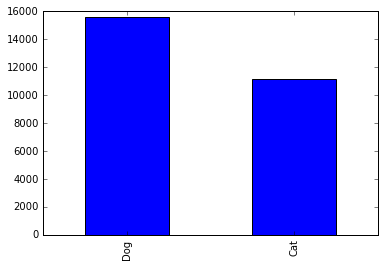

In [513]:
train['AnimalType'].value_counts().plot(kind='bar')

In [550]:
import re
import numpy as np
def AgeuponOutcome2Age(age):
    if pd.isnull(age):
        return age
    assert type(age) is str, age
    m = re.match(r'(\d+)\s+(\w+)', age)
    
    scale = {
        'day': 1,
        'week': 7,
        'month': 30,
        'year': 365,
    }
    number = int(m.groups(0)[0])
    interval = m.groups(0)[1]
    interval = interval if not interval.endswith('s') else interval[:-1] 
    return number*scale[interval]

In [551]:
train['Age'] = train['AgeuponOutcome'].map(AgeuponOutcome2Age)

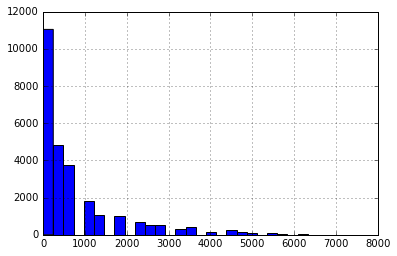

In [516]:
train['Age'].hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9877b2bdd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9877703b90>]], dtype=object)

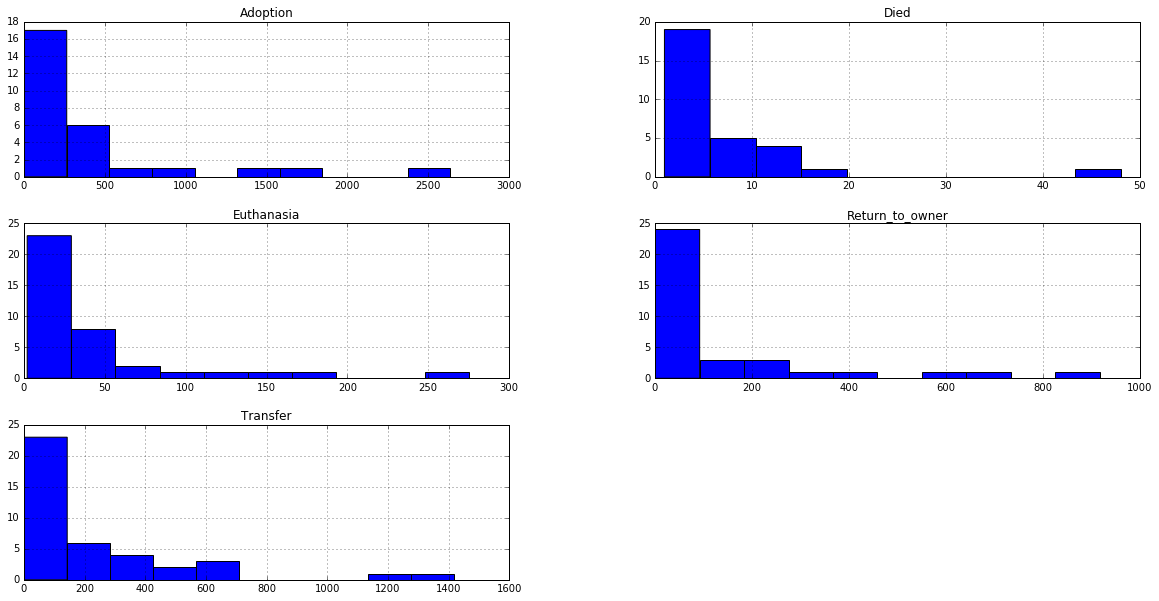

In [517]:
train.pivot_table(values='AnimalID', index='Age', columns='OutcomeType', aggfunc='count').hist(figsize=(20, 10))

In [518]:
for target_column in train['OutcomeType'].unique():
    train[target_column] = (train['OutcomeType'] == target_column).astype(int)

In [519]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age,Return_to_owner,Euthanasia,Adoption,Transfer,Died
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,365.0,1,0,0,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,365.0,0,1,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,730.0,0,0,1,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,21.0,0,0,0,1,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,730.0,0,0,0,1,0


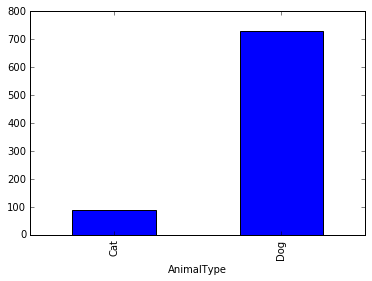

In [520]:
train.pivot_table(values='Age', index='AnimalType', aggfunc='median').plot(kind='bar')

In [587]:
train['AnimalType'] = train['AnimalType'].fillna('Dog')

train['Age'].fillna(value=train['Age'].median(), inplace=True)
# for animalType in train['AnimalType'].unique():
#     rows = train['AnimalType'] == animalType
#     train[rows]['Age'].fillna(value=train[rows]['Age'].median(), inplace=True)


train['CatOrDog'] = train['AnimalType'].map(lambda x: {'Cat': 0, 'Dog': 1}[x])
targets_encoder = {}
targets_decoder = {}
for i, target in enumerate(train['OutcomeType'].unique()):
    targets_encoder[target] = i
    targets_decoder[i] = target
train['OutcomeTypeEncoded'] = train["OutcomeType"].map(lambda t: targets_encoder[t])

train['HasName'] = (~train['Name'].isnull()).astype(int)

def MaleFemale(sex):
    if pd.isnull(sex):
        return sex
    if 'Male' in sex:
        return 1
    if 'Female' in sex:
        return 0
    return np.nan

def Intact(sex):
    if pd.isnull(sex):
        return np.nan
    if 'Intact' in sex:
        return 1
    if 'Neutered' in sex or 'Spayed' in sex:
        return 0
    return np.nan

train['Sex'] = train['SexuponOutcome'].map(MaleFemale)
train['Sex'].fillna(1, inplace=True)

train['Intact'] = train['SexuponOutcome'].map(Intact)

In [593]:
train['Intact'].value_counts(dropna=False)
train['Intact'].fillna(0, inplace=True)

In [570]:
train['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [594]:
from sklearn.cross_validation import train_test_split

features = ['CatOrDog', 'Age', 'HasName', 'Sex', 'Intact']
targets = 'OutcomeTypeEncoded'

X_train, X_test, y_train, y_test = train_test_split(train[features], train[targets], test_size=0.1)

In [595]:
train[features + train['OutcomeType'].unique().tolist()].corr()

,CatOrDog,Age,HasName,Sex,Intact,Return_to_owner,Euthanasia,Adoption,Transfer,Died
CatOrDog,1.000000,0.232501,0.304307,-0.001598,-0.191305,0.295644,-0.020186,0.033087,-0.251020,-0.057618
Age,0.232501,1.000000,0.231058,-0.014587,-0.143228,0.307592,0.150070,-0.147621,-0.164570,-0.023731
HasName,0.304307,0.231058,1.000000,-0.042625,-0.379714,0.263859,-0.129770,0.239370,-0.382965,-0.061175
Sex,-0.001598,-0.014587,-0.042625,1.000000,-0.045170,0.031113,0.027052,-0.064402,0.025243,0.014814
Intact,-0.191305,-0.143228,-0.379714,-0.045170,1.000000,-0.106766,0.170094,-0.428469,0.427445,0.082579
Return_to_owner,0.295644,0.307592,0.263859,0.031113,-0.106766,1.000000,-0.116072,-0.383627,-0.344587,-0.040243
Euthanasia,-0.020186,0.150070,-0.129770,0.027052,0.170094,-0.116072,1.000000,-0.204155,-0.183379,-0.021416
Adoption,0.033087,-0.147621,0.239370,-0.064402,-0.428469,-0.383627,-0.204155,1.000000,-0.606083,-0.070781
Transfer,-0.251020,-0.164570,-0.382965,0.025243,0.427445,-0.344587,-0.183379,-0.606083,1.000000,-0.063578
Died,-0.057618,-0.023731,-0.061175,0.014814,0.082579,-0.040243,-0.021416,-0.070781,-0.063578,1.000000


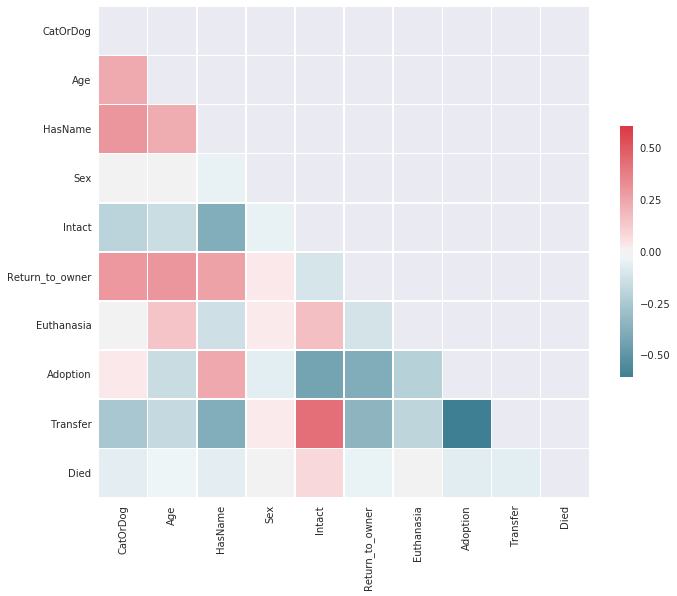

In [637]:
import seaborn as sns
corr = train[features + train['OutcomeType'].unique().tolist()].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [642]:
colors = map(lambda c: c.split('/'), train['Color'].unique())
np.unique(colors)

array([['Agouti'], ['Agouti', 'Brown Tabby'], ['Apricot'],
       ['Apricot', 'Brown'], ['Apricot', 'White'], ['Black'],
       ['Black', 'Black'], ['Black', 'Black Brindle'],
       ['Black', 'Black Smoke'], ['Black', 'Black Tabby'],
       ['Black', 'Blue'], ['Black', 'Blue Merle'], ['Black', 'Blue Tick'],
       ['Black', 'Brown'], ['Black', 'Brown Brindle'],
       ['Black', 'Brown Merle'], ['Black', 'Buff'], ['Black', 'Chocolate'],
       ['Black', 'Cream'], ['Black', 'Gray'], ['Black', 'Orange'],
       ['Black', 'Red'], ['Black', 'Silver'], ['Black', 'Silver Tabby'],
       ['Black', 'Tan'], ['Black', 'Tricolor'], ['Black', 'White'],
       ['Black', 'Yellow'], ['Black', 'Yellow Brindle'], ['Black Brindle'],
       ['Black Brindle', 'Black'], ['Black Brindle', 'Brown'],
       ['Black Brindle', 'Brown Brindle'], ['Black Brindle', 'White'],
       ['Black Smoke'], ['Black Smoke', 'Brown Tabby'],
       ['Black Smoke', 'White'], ['Black Tabby'],
       ['Black Tabby', 'Orange'], [

In [596]:
X_train.count()

CatOrDog    24056
Age         24056
HasName     24056
Sex         24056
Intact      24056
dtype: int64

best_n_estimators: 45, score: 0.651702207258


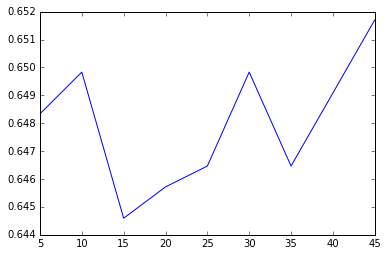

In [617]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

train_results = {
    'n_estimators_range': range(5, 50, 5),
    'scores': [],
}
n_estimators_range = range(5, 50, 5)


for n_estimators in train_results['n_estimators_range']:
    estimator = RandomForestClassifier(n_estimators=n_estimators)
    estimator.fit(X_train.values, y_train.values)
    train_results['scores'].append(estimator.score(X_test, y_test))

plt.plot(train_results['n_estimators_range'], train_results['scores'])
best_n_estimators = train_results['n_estimators_range'][np.argmax(train_results['scores'])]
print("best_n_estimators: {}, score: {}".format(best_n_estimators, np.max(train_results['scores'])))

In [618]:
estimator = RandomForestClassifier(n_estimators=best_n_estimators)
estimator.fit(train[features], train[targets])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [619]:
test = pd.read_csv('test.csv.gz')

In [625]:
test['Age'] = test['AgeuponOutcome'].map(AgeuponOutcome2Age)
test['Age'].fillna(train['Age'].median(), inplace=True)

   
test['AnimalType'] = test['AnimalType'].fillna('Dog')
test['CatOrDog'] = test['AnimalType'].map(lambda x: {'Cat': 0, 'Dog': 1}[x])

test['HasName'] = (~test['Name'].isnull()).astype(int)

test['Sex'] = test['SexuponOutcome'].map(MaleFemale)
test['Sex'].fillna(1, inplace=True)

test['Intact'] = test['SexuponOutcome'].map(Intact)
test['Intact'].fillna(0, inplace=True)

y_pred = estimator.predict_proba(test[features])

In [626]:
y_pred

array([[ 0.17262158,  0.        ,  0.        ,  0.82737842,  0.        ],
       [ 0.28049755,  0.02715813,  0.52953525,  0.16036634,  0.00244274],
       [ 0.114901  ,  0.00473291,  0.43943656,  0.44092953,  0.        ],
       ..., 
       [ 0.00365679,  0.09800532,  0.        ,  0.890909  ,  0.00742889],
       [ 0.44800318,  0.06058671,  0.30555912,  0.18585098,  0.        ],
       [ 0.53498469,  0.18314526,  0.01843323,  0.26343682,  0.        ]])

In [629]:
np.argmax(y_pred, axis=1)

array([3, 2, 3, ..., 3, 0, 0])

In [631]:
pred = pd.DataFrame(data={'ID': test['ID'].values, 'OutcomeType':np.argmax(y_pred, axis=1)})
pred['OutcomeType'] = pred['OutcomeType'].map(lambda t: targets_decoder[t])
for target_column in train['OutcomeType'].unique():
    pred[target_column] = y_pred[:, targets_encoder[target_column]]
pred.head()

,ID,OutcomeType,Return_to_owner,Euthanasia,Adoption,Transfer,Died
0,1,Transfer,0.172622,0.000000,0.000000,0.827378,0.000000
1,2,Adoption,0.280498,0.027158,0.529535,0.160366,0.002443
2,3,Transfer,0.114901,0.004733,0.439437,0.440930,0.000000
3,4,Transfer,0.165453,0.034665,0.030597,0.769286,0.000000
4,5,Adoption,0.342140,0.042044,0.428825,0.185427,0.001563


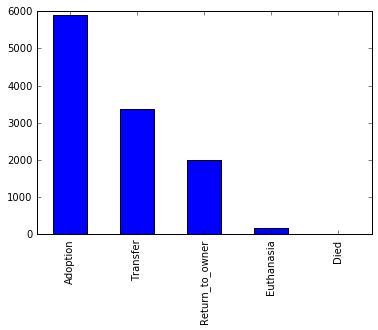

In [632]:
pred['OutcomeType'].value_counts().plot(kind='bar')

In [633]:
pred.to_csv('pred.csv', index=False, columns=['ID', 'Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])